<a href="https://colab.research.google.com/github/YasminaNasser/Stroke-Prediction-Data-Mining/blob/google-collab/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [16]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns




# Step 1 | Data overview


In [17]:
df=pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Step 2 | Preprocessing Techniques


### Function: `check_duplicate_rows(df, remove_duplicates=False)`

**Objective**:  
Detect and optionally remove duplicate rows from the dataset.

**Steps**:  
1. Identify duplicate rows using the `duplicated()` method.  
2. Print the count and details of duplicate rows, if any.  
3. Optionally, remove duplicates by setting `remove_duplicates=True` and using the `drop_duplicates()` method.  

**Importance**:  
- Ensures the dataset does not contain redundant information that could skew analyses or model training.


In [18]:
def check_duplicate_rows_with_visualization(df, correlation_threshold=0.95, remove_duplicates=False):
    """
    Check for duplicate rows, visualize the correlation matrix, and handle non-numeric data.
    Optionally remove exact duplicate rows.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        correlation_threshold (float): Threshold to flag columns as highly correlated.
        remove_duplicates (bool): Whether to remove exact duplicate rows.

    Returns:
        pd.DataFrame: The DataFrame with duplicates handled as specified.
    """
    print("------------------Visualizing Correlation Matrix------------------")

    # Handle non-numeric data by encoding or dropping
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
        #print(f"Encoding categorical column: {col}")
        df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

    # Calculate and visualize the correlation matrix
    corr_matrix = df_numeric.corr()

    # Print all the features in the correlation matrix
    print("\nFeatures in the Correlation Matrix:")
    print(corr_matrix.columns.tolist())

    # Print correlation values for 'id' column if it exists
    if 'id' in corr_matrix.columns:
        print("\nCorrelation values for 'id' column:")
        print(corr_matrix['id'])

    plt.figure(figsize=(8, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Analyze duplicate rows based on the correlation matrix
    duplicate_rows = df[df.duplicated()]
    print("\n------------------Checking for Duplicate Rows------------------")

    if not duplicate_rows.empty:
        print(f"Number of duplicate rows: {len(duplicate_rows)}")
        print("Duplicate Rows:\n", duplicate_rows)
    else:
        print("No exact duplicate rows found.")
        print("Note: Based on the correlation matrix, there are no duplicate rows.")

    # Remove duplicates if specified
    if remove_duplicates and not duplicate_rows.empty:
        df = df.drop_duplicates()
        print("\nDuplicate rows removed.")

    return df


Remove columns that do not contribute significantly to other columns based on the correlation matrix.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        threshold (float): The correlation threshold to flag a column as useless.
        reason (str): The reason provided when a column is detected as not contributing significantly.

    Returns:
        pd.DataFrame: The DataFrame with the useless columns removed.

In [19]:
def remove_useless_columns_using_correlation(df, threshold=0.003550, reason="The column is detected as not contributing significantly to other features."):

    # Handle non-numeric data by encoding them
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'category']).columns:
        df_numeric[col] = LabelEncoder().fit_transform(df_numeric[col])

    # Compute the correlation matrix
    correlation_matrix = df_numeric.corr()

    # Initialize a list to store columns to drop
    columns_to_drop = []

    # Ensure 'id' column is removed if it exists
    if 'id' in df.columns:
        columns_to_drop.append('id')
        print(f"Detected 'id' column, removing it. Reason: {reason}")

    # Iterate over each column and check its correlation with other columns
    for column in correlation_matrix.columns:
        # Get the correlations of the current column with all other columns (excluding itself)
        column_correlation = correlation_matrix[column].drop(column)

        # If all correlations are below the threshold, consider it as a useless column
        if all(abs(column_correlation) < threshold) and column not in columns_to_drop:
            columns_to_drop.append(column)
            print(f"Detected '{column}' column as not contributing significantly to other columns, removing it.")
            print(f"Reason: {reason}")

    # Drop the detected useless columns
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
        print(f"Columns dropped: {', '.join(columns_to_drop)}")
    else:
        print("No columns detected as useless based on the correlation threshold.")

    return df


### Function: `handle_numerical_missing_data_and_normalize(ds)`

**Objective**:  
Impute missing values in numerical columns and normalize their values to a standard range.

**Steps**:  
1. **Identify Numerical Features**:  
   - Select all columns with numerical data, excluding the last column (assumed to be the target column).
   
2. **Handle Missing Data**:  
   - Replace missing (`NaN`) values with the column mean using `SimpleImputer` from `sklearn`.

3. **Normalize Data**:  
   - Scale numerical features to a range of [0, 1] using `MinMaxScaler`.  
   - This ensures all numerical features have comparable scales, which is crucial for many machine learning algorithms.

4. Update the original dataset with the processed numerical features.

**Importance**:  
- Replacing missing values with meaningful statistics (mean) prevents loss of data.  
- Normalization eliminates the impact of differing scales across numerical features.


In [20]:
def handle_numerical_missing_data_and_normalize(ds):
    # Identify numerical features (excluding the last column)
    numerical_features = ds.iloc[:, :-1].select_dtypes(include=[np.number]).columns.tolist()
    print("------------------ Extracting Numerical Features ------------------")
    print(numerical_features)

    # Create a dataframe with only numerical features (excluding the target column)
    dataframe_N = ds[numerical_features]
    print("------------------ Numerical DataFrame ------------------------")
    print(dataframe_N)

    # Visualization of missing data before imputation (NaN values)
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe_N.isnull(), cbar=False, cmap='viridis', cbar_kws={'label': 'Missing Data'})
    plt.title('Missing Data Visualization (Before Imputation)')
    plt.show()

    # Handle missing data: Replace NaN values with the mean of the column
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    dataframe_N_imputed = imp_mean.fit_transform(dataframe_N)

    # Convert the NumPy array back to a DataFrame with the original column names
    dataframe_N_imputed = pd.DataFrame(dataframe_N_imputed, columns=numerical_features)

    # Normalize the data to a range of [0, 1]
    normalizer = MinMaxScaler(feature_range=(0, 1))
    dataframe_N_normalized = normalizer.fit_transform(dataframe_N_imputed)

    # Convert the normalized array back to a DataFrame with the original column names
    dataframe_N_normalized = pd.DataFrame(dataframe_N_normalized, columns=numerical_features)

    # Update the original dataset with the normalized numerical features
    ds[numerical_features] = dataframe_N_normalized

    print("------------------- Data After Handling Missing Values and Normalization ---------------")
    print(ds)

    return ds


### Function: `handle_categorical_missing_data(df)`

**Objective**:  
Replace missing and infrequent values in categorical features to maintain consistency.

**Steps**:  
1. **Extract Categorical Features**:  
   - Identify columns with categorical data (`object` type).

2. **Value Analysis**:  
   - Count the frequency of each value in the feature.  
   - Define frequent and infrequent values based on a threshold (1% of total rows).

3. **Replace Values**:  
   - Replace infrequent values and `NaN` with the most frequent value.  
   - This step ensures that rare or missing values do not disproportionately affect analyses or models.

4. Print updated value distributions for transparency.

**Importance**:  
- Standardizes categorical data, minimizing the noise introduced by infrequent or missing values.


In [21]:
def handle_categorical_missing_data(df):
    # Extract categorical features
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    print("------------------Extracting Categorical Features------------------")
    print("Categorical Features:", categorical_features)

    total_rows = len(df)
    threshold = total_rows * 0.001

    for feature in categorical_features:
        print(f"\nProcessing Feature: {feature}")

        # Get value counts for the feature
        value_counts = df[feature].value_counts(dropna=False)
        print(f"Value Counts:\n{value_counts}")

        # Identify frequent and infrequent values
        frequent_values = value_counts[value_counts > threshold].index
        infrequent_values = value_counts[value_counts <= threshold].index
        print(f"Frequent Values (Threshold > {threshold:.2f}): {list(frequent_values)}")
        print(f"Infrequent Values (Threshold <= {threshold:.2f}): {list(infrequent_values)}")

        # Replace infrequent values and NaNs with the most frequent value
        most_frequent_value = value_counts.idxmax()
        df[feature] = df[feature].apply(
            lambda x: x if x in frequent_values else most_frequent_value
        )

        print(f"Updated Feature Values:\n{df[feature].value_counts(dropna=False)}")
        print("-------------------------------------------------------------------")

    return df


# Step 3 | Outliers Detection and Handling


### Function: `detect_outliers(df, columns)`

**Objective**:  
Identify outliers in specified numerical columns using the Interquartile Range (IQR) method.

**Steps**:  
1. **Compute Quartiles and IQR**:  
   - Calculate the first quartile (Q1), third quartile (Q3), and the interquartile range (IQR) for each column.

2. **Define Outlier Bounds**:  
   - **Lower Bound**: \( Q1 - 1.5 \times IQR \)  
   - **Upper Bound**: \( Q3 + 1.5 \times IQR \)  

3. **Identify Outliers**:  
   - Detect rows where values fall outside these bounds.

4. **Log Details**:  
   - Record and display the details of outliers for each column.

**Importance**:  
- Helps identify extreme values that could skew analyses or model performance.  
- Provides insights into data quality.


In [22]:
def detect_outliers(df, columns, target_column='stroke'):
    outlier_indices = {}

    # Drop the target column if it's provided
    if target_column and target_column in columns:
        columns = [col for col in columns if col != target_column]

    print("------------------Detecting Outliers------------------")

    for column in columns:
        # Skip outlier detection if the column has only 2 unique values
        if df[column].nunique() <= 2:
            print(f"Skipping outlier detection for column '{column}' (only {df[column].nunique()} unique values).")
            continue

        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1                   # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if not outliers.empty:
            print(f"Outliers in column '{column}':")
            print(outliers)
            outlier_indices[column] = outliers.index.tolist()
        else:
            print(f"No outliers detected in column '{column}'.")

        # Create a box plot for the current column
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[column], color='lightblue')
        plt.title(f'Box Plot for {column} (Outliers Detection)')
        plt.show()

        # Create a scatter plot for outlier detection
        plt.figure(figsize=(6, 4))
        plt.scatter(df[column], np.zeros_like(df[column]), label='Data Points', alpha=0.6)

        # Highlight the outliers in the scatter plot
        plt.scatter(outliers[column], np.zeros_like(outliers[column]), color='red', label='Outliers', alpha=0.7)

        # Add thresholds as lines to indicate the bounds for outliers
        plt.axvline(lower_bound, color='green', linestyle='--', label=f'Lower Bound: {lower_bound}')
        plt.axvline(upper_bound, color='green', linestyle='--', label=f'Upper Bound: {upper_bound}')

        plt.title(f'Scatter Plot for {column} (Outliers Detection)')
        plt.xlabel(column)
        plt.yticks([])  # No y-axis since it's just for visualizing points
        plt.legend()
        plt.show()

    # Print a summary of all detected outliers
    print("\n------------------Summary of Detected Outliers------------------")
    if outlier_indices:
        for column, indices in outlier_indices.items():
            print(f"Outliers in column '{column}' at indices: {indices}")
    else:
        print("No outliers detected in any columns.")

    return outlier_indices


### Function: `cap_outliers(df, columns)`

**Objective**:  
Cap outliers in numerical columns to the IQR bounds, making them less extreme.

**Steps**:  
1. **Compute IQR-Based Bounds**:  
   - Calculate the lower and upper bounds using the IQR method:  
     - **Lower Bound**: \( Q1 - 1.5 \times IQR \)  
     - **Upper Bound**: \( Q3 + 1.5 \times IQR \)  

2. **Cap Outliers**:  
   - Replace values below the lower bound with the lower bound.  
   - Replace values above the upper bound with the upper bound.

**Importance**:  
- Reduces the impact of outliers without discarding data.  
- Helps stabilize models that are sensitive to extreme values, such as linear regression.


In [23]:
def cap_outliers(df, columns):
    capped_df = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds
        capped_df[column] = np.where(capped_df[column] < lower_bound, lower_bound,
                                     np.where(capped_df[column] > upper_bound, upper_bound, capped_df[column]))
    return capped_df

In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
file_path = '/content/healthcare-dataset-stroke-data.csv'
df_before = pd.read_csv(file_path)
df = pd.read_csv(file_path)
print("////////////////////DATA BEFORE PREPROCESSING///////////////////////")
print(df)

////////////////////DATA BEFORE PREPROCESSING///////////////////////
         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  

# Step 4 | Data Visualization


------------------Visualizing Correlation Matrix------------------

Features in the Correlation Matrix:
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Correlation values for 'id' column:
id                   1.000000
gender               0.002511
age                  0.003538
hypertension         0.003550
heart_disease       -0.001296
ever_married         0.013690
work_type           -0.015757
Residence_type      -0.001403
avg_glucose_level    0.001092
bmi                  0.003084
smoking_status       0.014074
stroke               0.006388
Name: id, dtype: float64


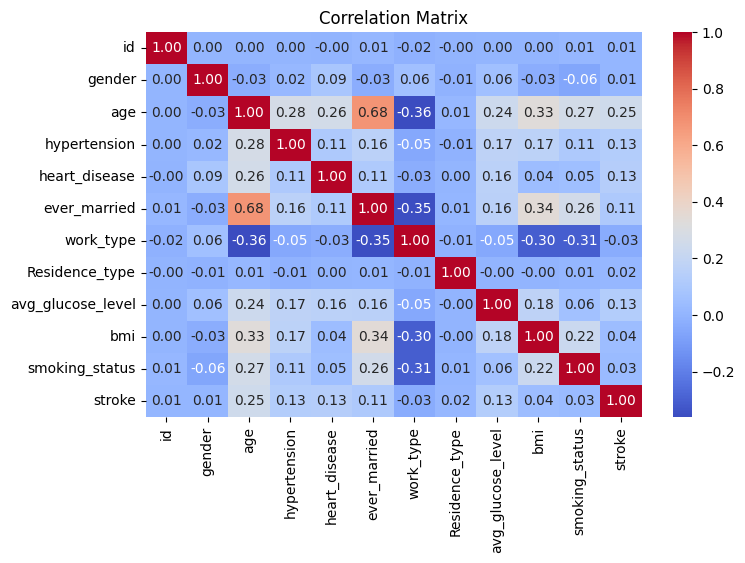


Correlation Matrix:
                         id    gender       age  hypertension  heart_disease  \
id                 1.000000  0.002511  0.003538      0.003550      -0.001296   
gender             0.002511  1.000000 -0.028202      0.020994       0.085447   
age                0.003538 -0.028202  1.000000      0.276398       0.263796   
hypertension       0.003550  0.020994  0.276398      1.000000       0.108306   
heart_disease     -0.001296  0.085447  0.263796      0.108306       1.000000   
ever_married       0.013690 -0.031005  0.679125      0.164243       0.114644   
work_type         -0.015757  0.056422 -0.361642     -0.051761      -0.028023   
Residence_type    -0.001403 -0.006738  0.014180     -0.007913       0.003092   
avg_glucose_level  0.001092  0.055180  0.238171      0.174474       0.161857   
bmi                0.003084 -0.026678  0.333398      0.167811       0.041357   
smoking_status     0.014074 -0.062581  0.265199      0.111038       0.048460   
stroke             

In [26]:
df = check_duplicate_rows_with_visualization(df)
df_before=df.copy()

In [27]:
df=remove_useless_columns_using_correlation(df)


Detected 'id' column, removing it. Reason: The column is detected as not contributing significantly to other features.
Columns dropped: id


*italicized text*# New Section

In [28]:
df = handle_categorical_missing_data(df)


------------------Extracting Categorical Features------------------
Categorical Features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Processing Feature: gender
Value Counts:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Frequent Values (Threshold > 5.11): ['Female', 'Male']
Infrequent Values (Threshold <= 5.11): ['Other']
Updated Feature Values:
gender
Female    2995
Male      2115
Name: count, dtype: int64
-------------------------------------------------------------------

Processing Feature: ever_married
Value Counts:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
Frequent Values (Threshold > 5.11): ['Yes', 'No']
Infrequent Values (Threshold <= 5.11): []
Updated Feature Values:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
-------------------------------------------------------------------

Processing Feature: work_type
Value Counts:
work_type
Private          2925
Self-employed     81

------------------ Extracting Numerical Features ------------------
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
------------------ Numerical DataFrame ------------------------
       age  hypertension  heart_disease  avg_glucose_level   bmi
0     67.0             0              1             228.69  36.6
1     61.0             0              0             202.21   NaN
2     80.0             0              1             105.92  32.5
3     49.0             0              0             171.23  34.4
4     79.0             1              0             174.12  24.0
...    ...           ...            ...                ...   ...
5105  80.0             1              0              83.75   NaN
5106  81.0             0              0             125.20  40.0
5107  35.0             0              0              82.99  30.6
5108  51.0             0              0             166.29  25.6
5109  44.0             0              0              85.28  26.2

[5110 rows x 5 col

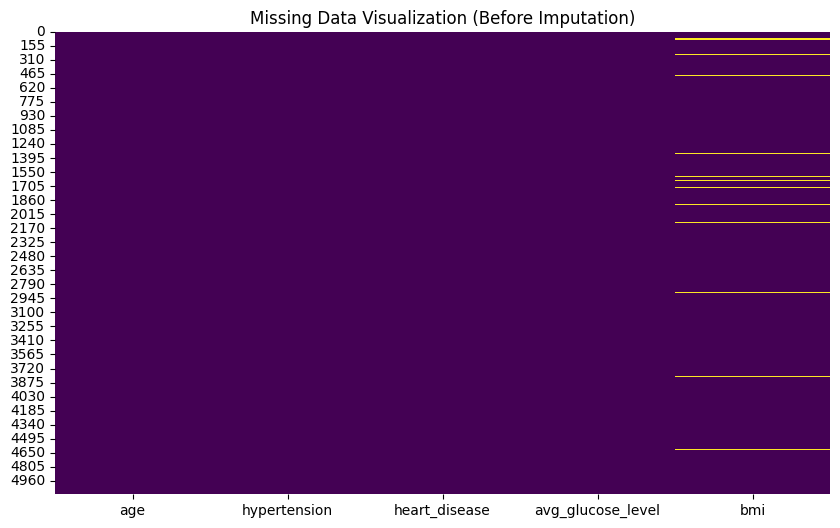

------------------- Data After Handling Missing Values and Normalization ---------------
      gender       age  hypertension  heart_disease ever_married  \
0       Male  0.816895           0.0            1.0          Yes   
1     Female  0.743652           0.0            0.0          Yes   
2       Male  0.975586           0.0            1.0          Yes   
3     Female  0.597168           0.0            0.0          Yes   
4     Female  0.963379           1.0            0.0          Yes   
...      ...       ...           ...            ...          ...   
5105  Female  0.975586           1.0            0.0          Yes   
5106  Female  0.987793           0.0            0.0          Yes   
5107  Female  0.426270           0.0            0.0          Yes   
5108    Male  0.621582           0.0            0.0          Yes   
5109  Female  0.536133           0.0            0.0          Yes   

          work_type Residence_type  avg_glucose_level       bmi  \
0           Private        

In [29]:
df = handle_numerical_missing_data_and_normalize(df)
df_before=df.copy()

------------------Detecting Outliers------------------
No outliers detected in column 'age'.


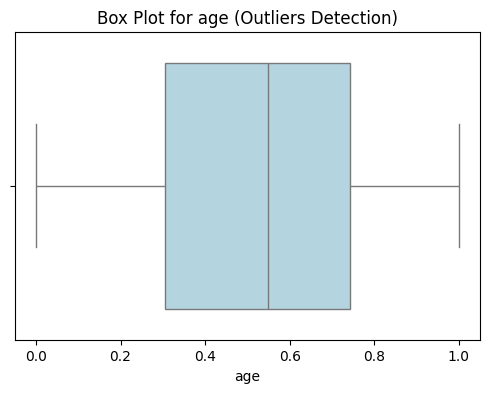

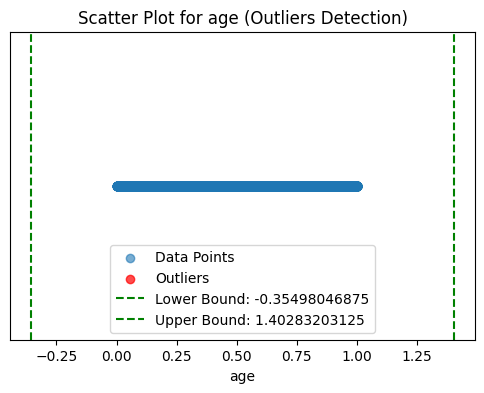

Skipping outlier detection for column 'hypertension' (only 2 unique values).
Skipping outlier detection for column 'heart_disease' (only 2 unique values).
Outliers in column 'avg_glucose_level':
      gender       age  hypertension  heart_disease ever_married  \
0       Male  0.816895           0.0            1.0          Yes   
1     Female  0.743652           0.0            0.0          Yes   
3     Female  0.597168           0.0            0.0          Yes   
4     Female  0.963379           1.0            0.0          Yes   
5       Male  0.987793           0.0            0.0          Yes   
...      ...       ...           ...            ...          ...   
5061    Male  0.499512           0.0            0.0          Yes   
5062  Female  1.000000           0.0            0.0          Yes   
5063    Male  0.475098           0.0            0.0          Yes   
5064    Male  0.853516           0.0            0.0          Yes   
5076  Female  0.414062           0.0            0.0      

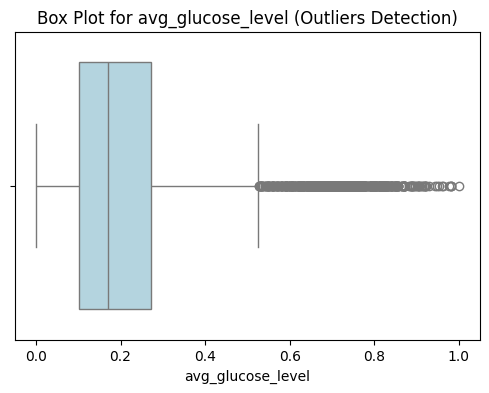

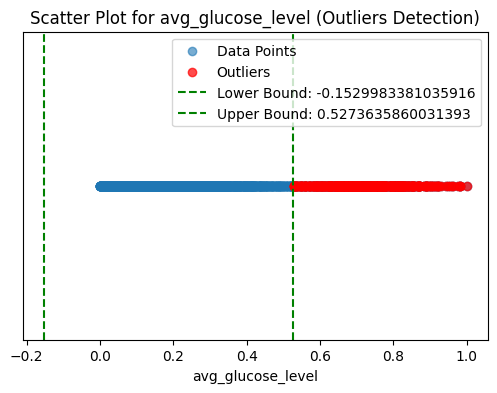

Outliers in column 'bmi':
      gender       age  hypertension  heart_disease ever_married  \
21    Female  0.633789           1.0            0.0          Yes   
66    Female  0.853516           0.0            0.0          Yes   
113   Female  0.548340           0.0            0.0          Yes   
254   Female  0.572754           0.0            0.0          Yes   
258   Female  0.902344           1.0            0.0          Yes   
...      ...       ...           ...            ...          ...   
4906  Female  0.645996           0.0            0.0          Yes   
4952    Male  0.621582           1.0            0.0          Yes   
5009  Female  0.609375           0.0            0.0          Yes   
5057  Female  0.597168           0.0            0.0          Yes   
5103  Female  0.218750           0.0            0.0           No   

          work_type Residence_type  avg_glucose_level       bmi  \
21    Self-employed          Urban           0.822500  0.442153   
66          Private    

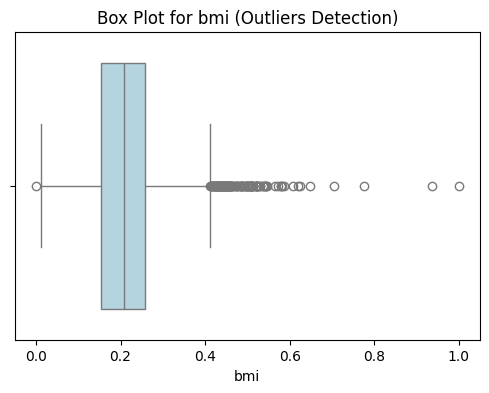

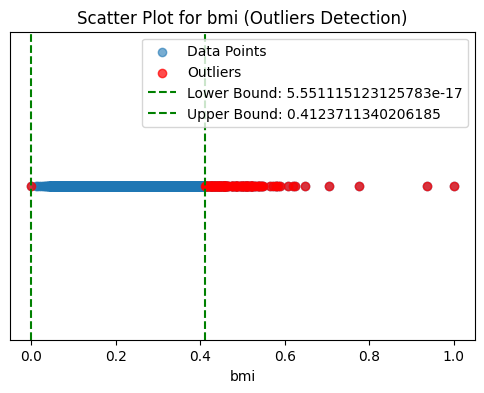


------------------Summary of Detected Outliers------------------
Outliers in column 'avg_glucose_level' at indices: [0, 1, 3, 4, 5, 13, 14, 16, 17, 19, 20, 21, 22, 23, 27, 28, 29, 30, 32, 33, 36, 44, 45, 54, 55, 57, 58, 59, 60, 66, 71, 73, 76, 90, 95, 97, 101, 102, 107, 113, 115, 122, 123, 124, 128, 130, 132, 134, 135, 137, 138, 139, 144, 149, 150, 151, 155, 157, 158, 163, 175, 179, 187, 189, 190, 193, 195, 196, 201, 212, 215, 217, 218, 219, 220, 222, 225, 226, 233, 234, 235, 241, 242, 243, 254, 256, 258, 272, 277, 278, 293, 298, 303, 307, 314, 318, 325, 326, 330, 331, 332, 337, 343, 350, 355, 360, 365, 386, 396, 399, 411, 417, 426, 429, 433, 436, 444, 456, 466, 467, 468, 477, 479, 492, 515, 544, 549, 551, 552, 559, 563, 570, 576, 581, 583, 585, 595, 598, 599, 610, 616, 620, 642, 706, 708, 719, 744, 746, 755, 762, 770, 785, 816, 846, 848, 851, 865, 867, 880, 887, 894, 923, 929, 930, 946, 948, 970, 971, 1011, 1059, 1061, 1067, 1070, 1071, 1092, 1097, 1102, 1104, 1113, 1118, 1131, 1158,

In [30]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
# Detect outliers
outlier_indices = detect_outliers(df, numerical_columns)

# Save outliers to a CSV file
outliers_df = df.loc[list(set(sum(outlier_indices.values(), [])))]
outliers_df.to_csv("outliers.csv", index=False)
print("\nOutliers exported to 'outliers.csv'.")

In [31]:
outlier_rows = list(set(sum(outlier_indices.values(), [])))  # Flatten indices
df_without_outliers = df.drop(index=outlier_rows)
# Cap outliers in the original dataframe
df_capped_outliers = cap_outliers(df, numerical_columns)
# Save results to CSV files
df_without_outliers.to_csv("data_without_outliers.csv", index=False)
print("\nDataset without outliers saved to 'data_without_outliers.csv'.")

df_capped_outliers.to_csv("data_capped_outliers.csv", index=False)
print("\nDataset with capped outliers saved to 'data_capped_outliers.csv'.")


Dataset without outliers saved to 'data_without_outliers.csv'.

Dataset with capped outliers saved to 'data_capped_outliers.csv'.


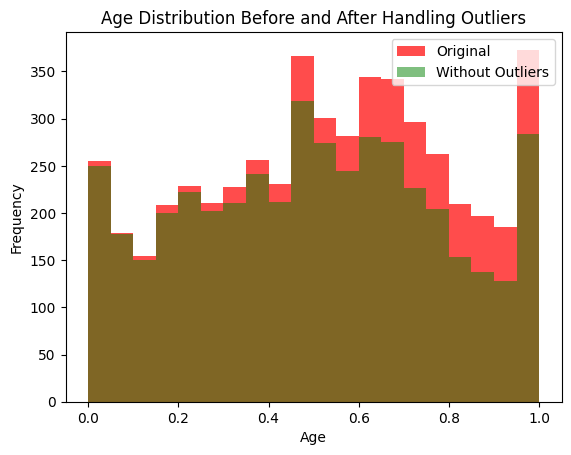

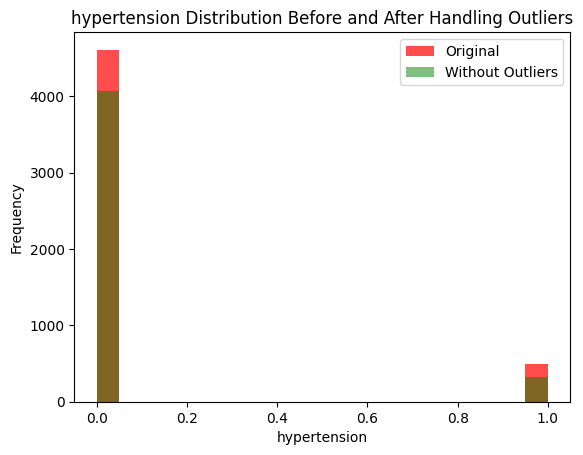

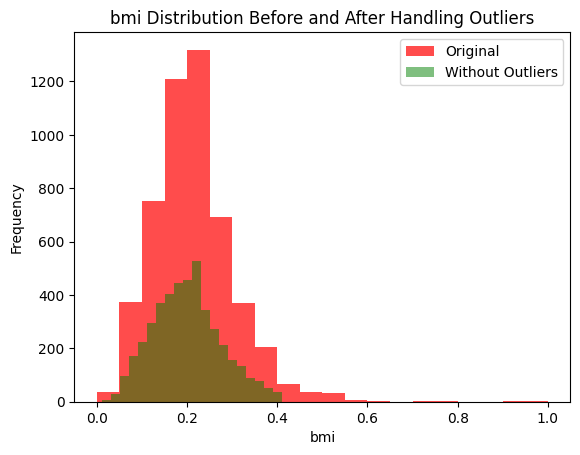

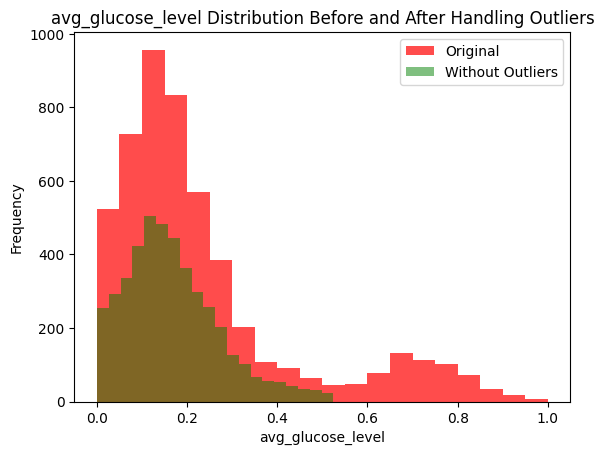

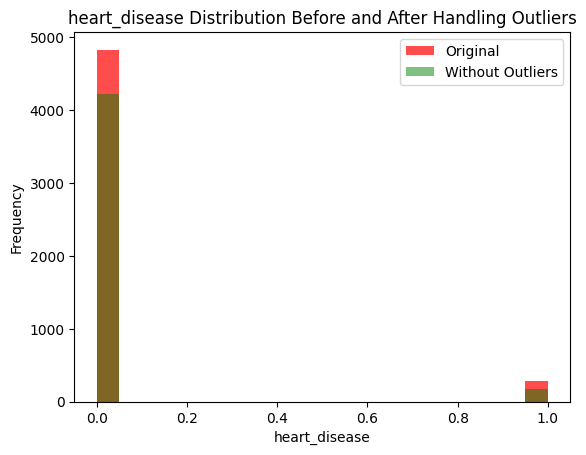

In [32]:
import matplotlib.pyplot as plt

# Example for the 'age' column (you can choose any numerical column)
plt.hist(df_before['age'], bins=20, color='red', alpha=0.7, label='Original')
plt.hist(df_without_outliers['age'], bins=20, color='green', alpha=0.5, label='Without Outliers')
# plt.hist(df_capped_outliers['age'], bins=20, color='orange', alpha=0.5, label='Capped Outliers')
plt.legend(loc='upper right')
plt.title('Age Distribution Before and After Handling Outliers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Example for the 'hypertension' column (you can choose any numerical column)
plt.hist(df_before['hypertension'], bins=20, color='red', alpha=0.7, label='Original')
plt.hist(df_without_outliers['hypertension'], bins=20, color='green', alpha=0.5, label='Without Outliers')
# plt.hist(df_capped_outliers['age'], bins=20, color='orange', alpha=0.5, label='Capped Outliers')
plt.legend(loc='upper right')
plt.title('hypertension Distribution Before and After Handling Outliers')
plt.xlabel('hypertension')
plt.ylabel('Frequency')
plt.show()

# Example for the 'bmi' column (you can choose any numerical column)
plt.hist(df_before['bmi'], bins=20, color='red', alpha=0.7, label='Original')
plt.hist(df_without_outliers['bmi'], bins=20, color='green', alpha=0.5, label='Without Outliers')
# plt.hist(df_capped_outliers['age'], bins=20, color='orange', alpha=0.5, label='Capped Outliers')
plt.legend(loc='upper right')
plt.title('bmi Distribution Before and After Handling Outliers')
plt.xlabel('bmi')
plt.ylabel('Frequency')
plt.show()

# Example for the 'bmi' column (you can choose any numerical column)
plt.hist(df_before['avg_glucose_level'], bins=20, color='red', alpha=0.7, label='Original')
plt.hist(df_without_outliers['avg_glucose_level'], bins=20, color='green', alpha=0.5, label='Without Outliers')
# plt.hist(df_capped_outliers['age'], bins=20, color='orange', alpha=0.5, label='Capped Outliers')
plt.legend(loc='upper right')
plt.title('avg_glucose_level Distribution Before and After Handling Outliers')
plt.xlabel('avg_glucose_level')
plt.ylabel('Frequency')
plt.show()

# Example for the 'bmi' column (you can choose any numerical column)
plt.hist(df_before['heart_disease'], bins=20, color='red', alpha=0.7, label='Original')
plt.hist(df_without_outliers['heart_disease'], bins=20, color='green', alpha=0.5, label='Without Outliers')
# plt.hist(df_capped_outliers['age'], bins=20, color='orange', alpha=0.5, label='Capped Outliers')
plt.legend(loc='upper right')
plt.title('heart_disease Distribution Before and After Handling Outliers')
plt.xlabel('heart_disease')
plt.ylabel('Frequency')
plt.show()
